# Prediction models by codes
In this notebook we consider ICD9 diagnosis and precedure codes as predictors to predict the 30-day readmission rate.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os

In [2]:
%matplotlib inline

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [3]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [4]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

## Data reading and splitting

In [5]:
core_dtypes_pd = {'AGE': float,
 'AWEEKEND': float,
 'DIED': float,
 'DISCWT': float,
 'DISPUNIFORM': float,
 'DMONTH': float,
 'DQTR': float,
 'DRG': float,
 'DRGVER': float,
 'DRG_NoPOA': float,
 'DX1': bytes,
 'DX10': bytes,
 'DX11': bytes,
 'DX12': bytes,
 'DX13': bytes,
 'DX14': bytes,
 'DX15': bytes,
 'DX16': bytes,
 'DX17': bytes,
 'DX18': bytes,
 'DX19': bytes,
 'DX2': bytes,
 'DX20': bytes,
 'DX21': bytes,
 'DX22': bytes,
 'DX23': bytes,
 'DX24': bytes,
 'DX25': bytes,
 'DX26': bytes,
 'DX27': bytes,
 'DX28': bytes,
 'DX29': bytes,
 'DX3': bytes,
 'DX30': bytes,
 'DX4': bytes,
 'DX5': bytes,
 'DX6': bytes,
 'DX7': bytes,
 'DX8': bytes,
 'DX9': bytes,
 'DXCCS1': float,
 'DXCCS10': float,
 'DXCCS11': float,
 'DXCCS12': float,
 'DXCCS13': float,
 'DXCCS14': float,
 'DXCCS15': float,
 'DXCCS16': float,
 'DXCCS17': float,
 'DXCCS18': float,
 'DXCCS19': float,
 'DXCCS2': float,
 'DXCCS20': float,
 'DXCCS21': float,
 'DXCCS22': float,
 'DXCCS23': float,
 'DXCCS24': float,
 'DXCCS25': float,
 'DXCCS26': float,
 'DXCCS27': float,
 'DXCCS28': float,
 'DXCCS29': float,
 'DXCCS3': float,
 'DXCCS30': float,
 'DXCCS4': float,
 'DXCCS5': float,
 'DXCCS6': float,
 'DXCCS7': float,
 'DXCCS8': float,
 'DXCCS9': float,
 'ECODE1': bytes,
 'ECODE2': bytes,
 'ECODE3': bytes,
 'ECODE4': bytes,
 'ELECTIVE': float,
 'E_CCS1': float,
 'E_CCS2': float,
 'E_CCS3': float,
 'E_CCS4': float,
 'FEMALE': float,
 'HCUP_ED': float,
 'HOSP_NRD': float,
 'KEY_NRD': float,
 'LOS': float,
 'MDC': float,
 'MDC_NoPOA': float,
 'NCHRONIC': float,
 'NDX': float,
 'NECODE': float,
 'NPR': float,
 'NRD_DaysToEvent': float,
 'NRD_STRATUM': float,
 'NRD_VisitLink': bytes,
 'ORPROC': float,
 'PAY1': float,
 'PL_NCHS': float,
 'PR1': bytes,
 'PR10': bytes,
 'PR11': bytes,
 'PR12': bytes,
 'PR13': bytes,
 'PR14': bytes,
 'PR15': bytes,
 'PR2': bytes,
 'PR3': bytes,
 'PR4': bytes,
 'PR5': bytes,
 'PR6': bytes,
 'PR7': bytes,
 'PR8': bytes,
 'PR9': bytes,
 'PRCCS1': float,
 'PRCCS10': float,
 'PRCCS11': float,
 'PRCCS12': float,
 'PRCCS13': float,
 'PRCCS14': float,
 'PRCCS15': float,
 'PRCCS2': float,
 'PRCCS3': float,
 'PRCCS4': float,
 'PRCCS5': float,
 'PRCCS6': float,
 'PRCCS7': float,
 'PRCCS8': float,
 'PRCCS9': float,
 'PRDAY1': float,
 'PRDAY10': float,
 'PRDAY11': float,
 'PRDAY12': float,
 'PRDAY13': float,
 'PRDAY14': float,
 'PRDAY15': float,
 'PRDAY2': float,
 'PRDAY3': float,
 'PRDAY4': float,
 'PRDAY5': float,
 'PRDAY6': float,
 'PRDAY7': float,
 'PRDAY8': float,
 'PRDAY9': float,
 'REHABTRANSFER': float,
 'RESIDENT': float,
 'SAMEDAYEVENT': bytes,
 'SERVICELINE': float,
 'TOTCHG': float,
 'YEAR': float,
 'ZIPINC_QRTL': float}

Read the same admissions as in the comorbidities dataset, but the variables from the core data set:

In [6]:
ami_index = pd.read_csv(path+'cohorts/ami_index.csv', dtype=core_dtypes_pd)

train_comorb = pd.read_csv(path+'cohorts/ami/comorb_train.csv')
test_comorb = pd.read_csv(path+'cohorts/ami/comorb_test.csv')

train_df = ami_index[ami_index['KEY_NRD'].isin(train_comorb['KEY_NRD'])]
tst_df = ami_index[ami_index['KEY_NRD'].isin(test_comorb['KEY_NRD'])]

N_train = len(train_df)
N_tst = len(tst_df)
all_df = pd.concat([train_df, tst_df])

del(ami_index, train_comorb, test_comorb)

## Prediction by raw ICD9 diagnosis codes

In [7]:
from keras.layers import Input, Embedding, concatenate, Reshape, BatchNormalization, add
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc

### Data Preparation

DX2-DX30 are considered as categorical variables that share levels (around 6000 levels). We change their values into integers from 0 to number of levels, so that they can feed into embedding layers. 

In [9]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

In [10]:
DX_series = pd.concat([all_df[DX] for DX in DXs])

DX_series = DX_series.replace('invl', np.nan).replace('incn', np.nan).astype('category')
DX_cat = DX_series.cat.categories

n_DX_cat = len(DX_cat)

DX_int_cat = range(n_DX_cat)
DX_dict = dict(zip(DX_cat, DX_int_cat))

In [11]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)

N_trn = len(trn_df)
N_val = len(val_df)

train_df = pd.concat([trn_df, val_df])

In [12]:
DX_ohe = np.zeros((len(train_df), n_DX_cat))

DX_mat = train_df[DXs].replace('invl', np.nan).replace('incn', np.nan).values

for j in range(DX_mat.shape[0]):
    for i in range(DX_mat.shape[1]):
        if not DX_mat[j, i] is np.nan:
            DX_ohe[j, DX_dict[DX_mat[j, i]]] = 1

DX_ohe_trn = DX_ohe[:N_trn, ]
DX_ohe_val = DX_ohe[N_trn:, ]

The demographic variables are age and gender. Age is normalized to the same scale as other variables. 

In [13]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

demo_mat_trn = demo_mat[:N_trn, ]
demo_mat_val = demo_mat[N_trn:, ]

Hospital is a categorical variable with around 800 levels. It will be processed as embedding, just like DXns.

In [14]:
hosp_series = train_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_series = hosp_series.cat.rename_categories(range(len(hosp_cat)))
hosp_array = hosp_series.astype(int).values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

DX1 is a categorical variable with 20 levels. It will be transformed into one-hot-encoding matrix before feed into neural nets. 

In [15]:
DX1_series = train_df['DX1'].astype('category')
DX1_cat = DX1_series.cat.categories
DX1_int_cat = range(len(DX1_cat))

DX1_dict = dict(zip(DX1_cat, DX1_int_cat))

DX1_mat = np.zeros((len(DX1_series), len(DX1_cat)))

for i, dx1 in enumerate(DX1_series.values):
    DX1_mat[i, DX1_dict[dx1]] = 1

DX1_mat_trn = DX1_mat[:N_trn, ]
DX1_mat_val = DX1_mat[N_trn:, ]

The label/outcome in this problem is the whether there is an unexpected all-cause 30-day readmission following this index admission. It is considered as an integer with value 0 and 1. 

In [16]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

In [34]:
n_DX_cat

5455

### Model Building

In [17]:
from keras_addon import AUCCheckPoint

In [18]:
hosp_embed_dim = 1

input_DX = Input(shape = (n_DX_cat,))

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, input_DX, hosp_embed], axis=1)

x = Dense(1024, activation='relu')(merged)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [19]:
adam = Adam(lr=0.00002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
checkpointer = AUCCheckPoint(filepath=model_path+'ami_icd9_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [21]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [55]:
class_weight = {0:1., 1:1.}

In [22]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_ohe_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=20, callbacks=[checkpointer, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val], Y_val], 
                verbose=2)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20


InternalError: Failed to create session.

### Model Testing

In [18]:
DX_ohe_tst = np.zeros((len(tst_df), n_DX_cat))

DX_mat_tst = tst_df[DXs].replace('invl', np.nan).replace('incn', np.nan).values

for j in range(DX_mat_tst.shape[0]):
    for i in range(DX_mat_tst.shape[1]):
        if not DX_mat_tst[j, i] is np.nan:
            DX_ohe_tst[j, DX_dict[DX_mat_tst[j, i]]] = 1

In [19]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values

demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

In [20]:
hosp_array_tst = tst_df['HOSP_NRD'].astype('category').cat.rename_categories(range(len(hosp_cat))).astype(int).values

In [21]:
DX1_array_tst = tst_df['DX1'].astype('category').values

DX1_mat_tst = np.zeros((len(DX1_array_tst), len(DX1_cat)))
for i, dx1 in enumerate(DX1_array_tst):
    DX1_mat_tst[i, DX1_dict[dx1]] = 1

In [22]:
y_tst = tst_df['readm30'].values.astype(int)

Y_tst = to_categorical(y_tst)

In [87]:
model.load_weights(model_path+'ami_icd9_auc1.h5')

y_pred = model.predict([demo_mat_tst, DX1_mat_tst, DX_ohe_tst, hosp_array_tst], batch_size=256, verbose=1)

18186/18186 [==============================] - 1s 62us/step


{0: 0.6958997475099525}

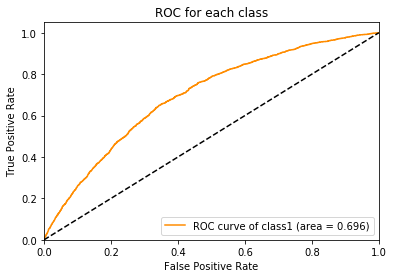

In [88]:
plot_roc(y_pred[:, 1], Y_tst[:, 1])

## Additive Emedding

### Model Building

In [32]:
DX_embed_dim = 100
hosp_embed_dim = 3

input_DX = Input(shape = (n_DX_cat,))
DX_embed = Dense(DX_embed_dim)(input_DX)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_embed, hosp_embed], axis=1)

x = Dense(128, activation='relu')(merged)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [24]:
merged.shape

TensorShape([Dimension(None), Dimension(125)])

In [33]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
checkpointer = AUCCheckPoint(filepath=model_path+'ami_icd9_addembed_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=5)

In [35]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [55]:
class_weight = {0:1., 1:1.}

In [36]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_ohe_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=30, callbacks=[checkpointer, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val], Y_val], 
                verbose=2)

Train on 145667 samples, validate on 18004 samples
Epoch 1/30
 - 5s - loss: 1.3296 - acc: 0.6148 - val_loss: 0.6502 - val_acc: 0.6400
AUC: 0.6888

Epoch 2/30
 - 5s - loss: 1.2760 - acc: 0.6442 - val_loss: 0.6379 - val_acc: 0.6361
AUC: 0.6969

Epoch 3/30
 - 5s - loss: 1.2589 - acc: 0.6444 - val_loss: 0.6395 - val_acc: 0.6256
AUC: 0.6995

Epoch 4/30
 - 5s - loss: 1.2462 - acc: 0.6483 - val_loss: 0.6474 - val_acc: 0.6191
AUC: 0.6995

Epoch 5/30
 - 4s - loss: 1.2357 - acc: 0.6518 - val_loss: 0.6408 - val_acc: 0.6250
AUC: 0.6989

Epoch 6/30
 - 4s - loss: 1.2234 - acc: 0.6567 - val_loss: 0.6373 - val_acc: 0.6290
AUC: 0.6971

Epoch 7/30
 - 4s - loss: 1.2125 - acc: 0.6596 - val_loss: 0.6046 - val_acc: 0.6579
AUC: 0.6960

Epoch 8/30
 - 4s - loss: 1.2005 - acc: 0.6642 - val_loss: 0.6170 - val_acc: 0.6461
AUC: 0.6934

Epoch 9/30
 - 5s - loss: 1.1890 - acc: 0.6663 - val_loss: 0.6201 - val_acc: 0.6440
AUC: 0.6922

Epoch 10/30
 - 4s - loss: 1.1777 - acc: 0.6705 - val_loss: 0.5907 - val_acc: 0.6680
A

### Model Testing

In [37]:
model.load_weights(model_path+'ami_icd9_addembed_auc1.h5')
y_pred = model.predict([demo_mat_tst, DX1_mat_tst, DX_ohe_tst, hosp_array_tst], batch_size=256, verbose=1)

18186/18186 [==============================] - 1s 61us/step


{0: 0.6955175900340639}

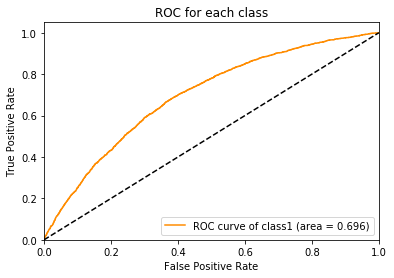

In [38]:
plot_roc(y_pred[:, 1], Y_tst[:, 1])

## Prediction by Single-Level CSS codes

### Data Preparation

DX2-DX30 are considered as categorical variables that share levels (around 6000 levels). We change their values into integers from 0 to number of levels, so that they can feed into embedding layers. 

In [49]:
N_DX = 29
DXCCSs = ['DXCCS'+str(n) for n in range(2, N_DX+2)]

In [56]:
DXCCS_series = pd.concat([all_df[DXCCS] for DXCCS in DXCCSs])

In [57]:
DXCCS_series = DXCCS_series.astype('category')

DXCCS_cat = DXCCS_series.cat.categories

In [59]:
n_DXCCS_cat = len(DXCCS_cat)

DXCCS_int_cat = range(n_DXCCS_cat)
DXCCS_dict = dict(zip(DXCCS_cat, DXCCS_int_cat))

In [11]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)

N_trn = len(trn_df)
N_val = len(val_df)

train_df = pd.concat([trn_df, val_df])

In [75]:
DXCCS_ohe = np.zeros((len(train_df), n_DXCCS_cat))

DXCCS_mat = train_df[DXCCSs].values

for j in range(DXCCS_mat.shape[0]):
    for i in range(DXCCS_mat.shape[1]):
        if not np.isnan(DXCCS_mat[j, i]):
            DXCCS_ohe[j, DXCCS_dict[DXCCS_mat[j, i]]] = 1

DXCCS_ohe_trn = DXCCS_ohe[:N_trn, ]
DXCCS_ohe_val = DXCCS_ohe[N_trn:, ]

The demographic variables are age and gender. Age is normalized to the same scale as other variables. 

In [13]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

demo_mat_trn = demo_mat[:N_trn, ]
demo_mat_val = demo_mat[N_trn:, ]

Hospital is a categorical variable with around 800 levels. It will be processed as embedding, just like DXns.

In [14]:
hosp_series = train_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_series = hosp_series.cat.rename_categories(range(len(hosp_cat)))
hosp_array = hosp_series.astype(int).values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

DX1 is a categorical variable with 20 levels. It will be transformed into one-hot-encoding matrix before feed into neural nets. 

In [15]:
DX1_series = train_df['DX1'].astype('category')
DX1_cat = DX1_series.cat.categories
DX1_int_cat = range(len(DX1_cat))

DX1_dict = dict(zip(DX1_cat, DX1_int_cat))

DX1_mat = np.zeros((len(DX1_series), len(DX1_cat)))

for i, dx1 in enumerate(DX1_series.values):
    DX1_mat[i, DX1_dict[dx1]] = 1

DX1_mat_trn = DX1_mat[:N_trn, ]
DX1_mat_val = DX1_mat[N_trn:, ]

The label/outcome in this problem is the whether there is an unexpected all-cause 30-day readmission following this index admission. It is considered as an integer with value 0 and 1. 

In [16]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

In [34]:
n_DX_cat

5455

### Model Building

In [17]:
from keras_addon import AUCCheckPoint

In [116]:
hosp_embed_dim = 1

input_DXCCS = Input(shape = (n_DXCCS_cat,))

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, input_DXCCS, hosp_embed], axis=1)

x = Dense(256, activation='relu')(merged)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DXCCS, input_hosp], outputs=prediction)

In [117]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
checkpointer = AUCCheckPoint(filepath=model_path+'ami_icd9dxccs_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DXCCS_ohe_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [90]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [119]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DXCCS_ohe_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=30, callbacks=[checkpointer, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DXCCS_ohe_val, hosp_array_val], Y_val], 
                verbose=2)

Train on 145667 samples, validate on 18004 samples
Epoch 1/30
 - 2s - loss: 1.3235 - acc: 0.5831 - val_loss: 0.6528 - val_acc: 0.6254
AUC: 0.6816

Epoch 2/30
 - 1s - loss: 1.2918 - acc: 0.6196 - val_loss: 0.6397 - val_acc: 0.6236
AUC: 0.6866

Epoch 3/30
 - 1s - loss: 1.2834 - acc: 0.6198 - val_loss: 0.6487 - val_acc: 0.6111
AUC: 0.6891

Epoch 4/30
 - 2s - loss: 1.2778 - acc: 0.6182 - val_loss: 0.6310 - val_acc: 0.6230
AUC: 0.6914

Epoch 5/30
 - 1s - loss: 1.2722 - acc: 0.6216 - val_loss: 0.6562 - val_acc: 0.5981
AUC: 0.6922

Epoch 6/30
 - 1s - loss: 1.2685 - acc: 0.6185 - val_loss: 0.6227 - val_acc: 0.6311
AUC: 0.6933

Epoch 7/30
 - 1s - loss: 1.2645 - acc: 0.6245 - val_loss: 0.6370 - val_acc: 0.6148
AUC: 0.6944

Epoch 8/30
 - 1s - loss: 1.2607 - acc: 0.6243 - val_loss: 0.6244 - val_acc: 0.6252
AUC: 0.6957

Epoch 9/30
 - 1s - loss: 1.2565 - acc: 0.6272 - val_loss: 0.6384 - val_acc: 0.6143
AUC: 0.6964

Epoch 10/30
 - 1s - loss: 1.2519 - acc: 0.6265 - val_loss: 0.6335 - val_acc: 0.6194
A

In [82]:
DXCCS_ohe_tst = np.zeros((len(tst_df), n_DXCCS_cat))

DXCCS_mat_tst = tst_df[DXCCSs].values

for j in range(DXCCS_mat_tst.shape[0]):
    for i in range(DXCCS_mat_tst.shape[1]):
        if not np.isnan(DXCCS_mat_tst[j, i]):
            DXCCS_ohe_tst[j, DXCCS_dict[DXCCS_mat_tst[j, i]]] = 1

In [120]:
model.load_weights(model_path+'ami_icd9dxccs_auc1.h5')
y_pred = model.predict([demo_mat_tst, DX1_mat_tst, DXCCS_ohe_tst, hosp_array_tst], batch_size=256, verbose=1)

18186/18186 [==============================] - 0s 8us/step


{0: 0.6920043097142405}

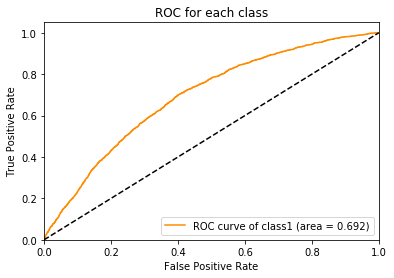

In [121]:
plot_roc(y_pred[:, 1], Y_tst[:, 1])

## Prediction by Multi-Level CSS codes

In [41]:
multi_ccs = pd.read_csv(path+'ccs_multi_dx_tool_2015.csv')

In [45]:
multi_ccs.columns = ['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL1_LABEL', 'CCS_LVL2', 'CCS_LVL2_LABEL', 'CCS_LVL3', 'CCS_LVL3_LABEL', 
                    'CCS_LVL4', 'CCS_LVL4_LABEL']

In [46]:
multi_ccs = multi_ccs[['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL2', 'CCS_LVL3', 'CCS_LVL4']]

In [48]:
multi_ccs.CCS_LVL1.value_counts()

'16'    2764
'18'    1589
'6'     1587
'1'     1226
'11'    1205
'2'     1114
'13'     863
'9'      757
'5'      607
'7'      553
'10'     498
'3'      445
'14'     444
'17'     403
'15'     351
'8'      342
'12'     190
'4'      134
Name: CCS_LVL1, dtype: int64

#### Save data for hyper parameter tuning:

In [63]:
np.savez(path+'temp/data_temp.npz', demo_mat=demo_mat, DX1_mat=DX1_mat, DX_mat=DX_mat, hosp_array=hosp_array, y_train=y_train, 
        y_test=y_test, n_DX_cat=n_DX_cat, n_DX1_cat = len(DX1_cat), n_hosp_cat=len(hosp_cat))

### Hyper Tuning

In [6]:
with open('output/hyper_tune_large.csv', 'w') as f:
    f.write('depth,width,DX_dim,hosp_dim,lr,dropout,batchsize,auc\n')

In [4]:
hyper_df = pd.read_csv('./hyper_tune.csv')

In [5]:
hyper_df[hyper_df['auc']>0.59]

,depth,width,DX_dim,hosp_dim,auc
7,20,128,5,5,0.592
22,10,128,50,3,0.592
30,3,128,5,1,0.604
33,1,64,5,5,0.591
35,3,64,10,5,0.598
